In [65]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
df = pd.read_csv("water_potability.csv")
df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


### Dropping NaN values

In [67]:
df = df.dropna()

## Looking at data correlation

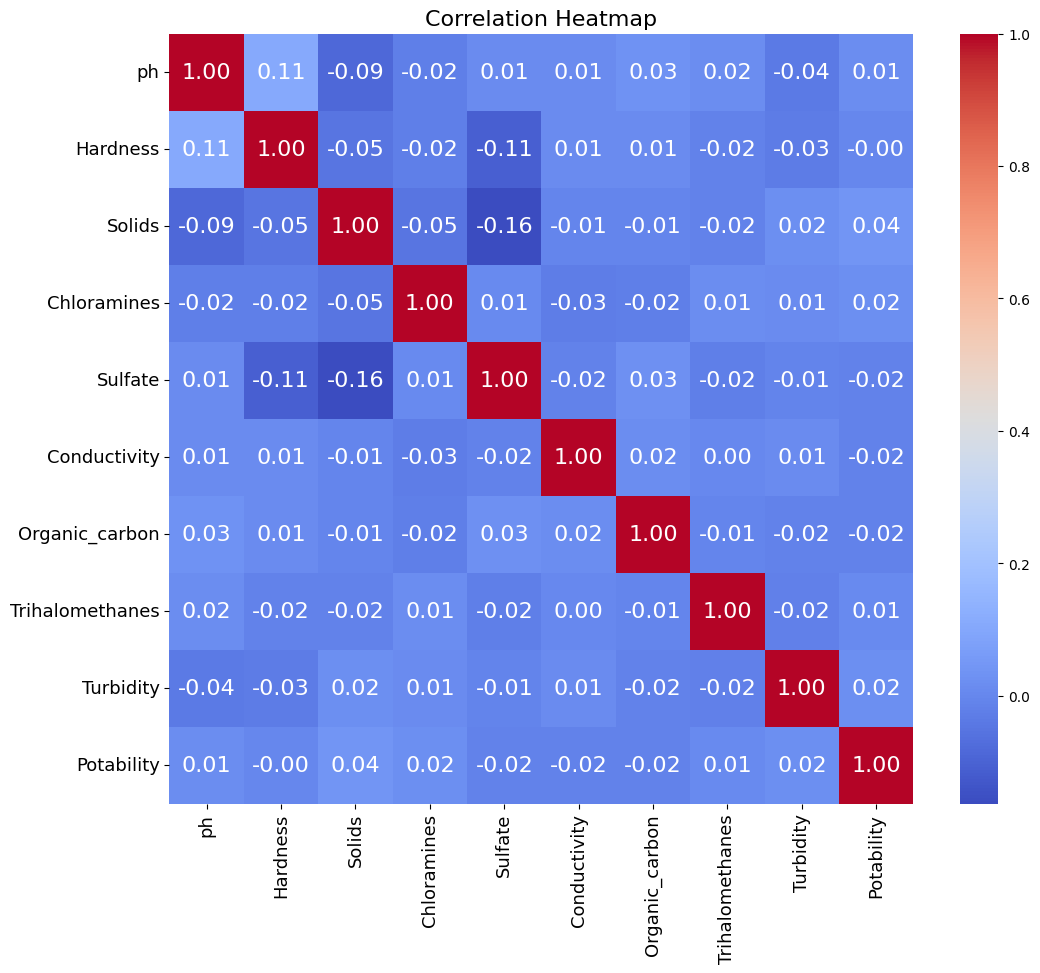

In [68]:
corr = df.corr()
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f",
            annot_kws={"fontsize": 16})  # Adjust fontsize as needed
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=13)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=13)
plt.title("Correlation Heatmap", fontsize=16)  # Adjust fontsize as needed
plt.show()

# Defining X, y

In [60]:
X, y = df.drop("Potability", axis=1), df["Potability"]
X

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425
...,...,...,...,...,...,...,...,...,...
3267,8.989900,215.047358,15921.412018,6.297312,312.931022,390.410231,9.899115,55.069304,4.613843
3268,6.702547,207.321086,17246.920347,7.708117,304.510230,329.266002,16.217303,28.878601,3.442983
3269,11.491011,94.812545,37188.826022,9.263166,258.930600,439.893618,16.172755,41.558501,4.369264
3270,6.069616,186.659040,26138.780191,7.747547,345.700257,415.886955,12.067620,60.419921,3.669712


# Splitting data into train and test

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating our tree with max depth 3

In [62]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

p, r, f, _ = precision_recall_fscore_support(y_test, dt.predict(X_test), labels=[0, 1])
display(f"precision: {p}")
display(f"recall: {r}")
display(f"f-score: {f}")


'precision: [0.58974359 0.92307692]'

'recall: [0.995671   0.06976744]'

'f-score: [0.74074074 0.12972973]'

# Creating our tree with max depth 6

In [70]:
dt = DecisionTreeClassifier(max_depth=6)
dt.fit(X_train, y_train)

p, r, f, _ = precision_recall_fscore_support(y_test, dt.predict(X_test), labels=[0, 1])
display(f"precision: {p}")
display(f"recall: {r}")
display(f"f-score: {f}")


'precision: [0.63414634 0.69333333]'

'recall: [0.9004329  0.30232558]'

'f-score: [0.74418605 0.42105263]'